# Improving neural network performance Part 1 - Hyperparameter tuning and regularization

In [ ]:
# Library om YouTube videos te importeren 

from IPython.display import YouTubeVideo, Image

* Overfitting and underfitting
* Hyperparameters
 - Neurons & layers
 - Learning rate
 - Batch size
* Early stopping
* Regularization
* Batch normalization
* Dropout

## 1 Overfitting and underfitting

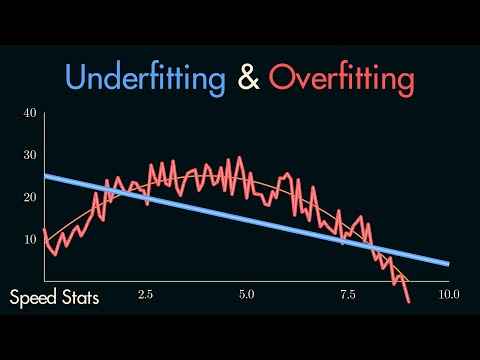

In [ ]:
YouTubeVideo("o3DztvnfAJg", width=800, height=500)

### 1.1 Definitions

In machine learning, we use models to make predictions based on input data. To do so, we train the model on available data that we have. This data is called the training data. However, the goal is to create a model that can accurately predict on **new data that it hasn't seen before**. In other words, we want our model to **generalize** to unseen data. This is why we usually hold some of the available data apart when training the model, and then evaluate the model's performance on the held-apart data. This held-apart data is called the test data.

"Underfitting" occurs when a model is too simple and doesn't capture the underlying patterns in the data. In other words, it doesn't fit the training data very well and also doesn't perform well on new data. An underfit model has **high bias and low variance**.

"On the other hand, "overfitting" occurs when a model is too complex and fits the training data too closely. In other words, it fits the training data too well and doesn't generalize well to new data. An overfit model has **low bias and high variance**.

A model that is just right, with a good balance between complexity and fit, is said to have good generalization performance. The goal is to create a model that fits the data well but also generalizes well to new data. This is called the "bias-variance tradeoff".

The bias-variance tradeoff refers to the fact that simpler models have higher bias (i.e., they underfit) but lower variance, while more complex models have lower bias (i.e., they fit the training data better) but higher variance. The challenge is to find the right balance between bias and variance to create a model that has good generalization performance.

The following code is used simply to illustrate this concept. In this code, we train 3 models, one with a low complexity, one with a higher complexity, and one with an extremely high complexity. We see how the low-complexity model does not fit the training data well, and the extremely high complexity model fits the training data very well, but completely fails to generalize.

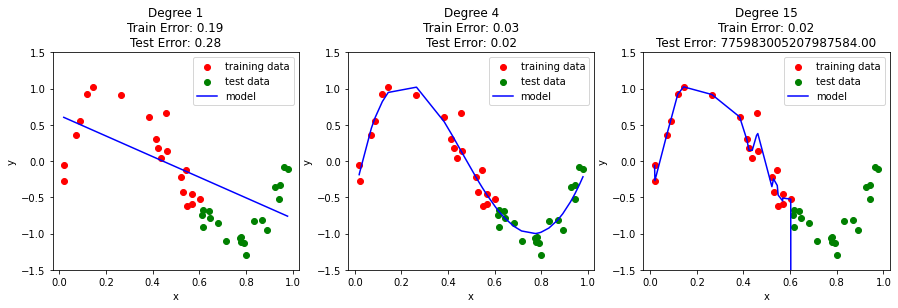

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate a synthetic dataset
np.random.seed(0)
n_samples = 40
X = np.sort(np.random.rand(n_samples))
y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.2

# Split the data into training and test sets
X_train, y_train = X[:20], y[:20]
X_test, y_test = X[20:], y[20:]

# Train polynomial regression models with different degrees of polynomial
degrees = [1, 4, 15]
fig, axes = plt.subplots(1, len(degrees), figsize=(15, 4))
for i, degree in enumerate(degrees):
    # Create a polynomial regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    # Train the model on the training data
    model.fit(X_train.reshape(-1, 1), y_train)

    # Compute the mean squared error on the training and test data
    train_error = mean_squared_error(y_train, model.predict(X_train.reshape(-1, 1)))
    test_error = mean_squared_error(y_test, model.predict(X_test.reshape(-1, 1)))

    # Plot the model predictions on the training and test data
    ax = axes[i]
    ax.scatter(X_train, y_train, color='red', label='training data')
    ax.scatter(X_test, y_test, color='green', label='test data')
    ax.plot(X, model.predict(X.reshape(-1, 1)), color='blue', label='model')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(f'Degree {degree}\nTrain Error: {train_error:.2f}\nTest Error: {test_error:.2f}')
    ax.legend()

plt.show()


For the rest of this notebook we are going to understand three broad concepts:
1. How do we identify underfitting and overfitting in a neural network?
2. What can we do to address underfitting?
3. What can we do to address overfitting?

In this notebook, we will demonstrate these concepts using a simple non-linear regression problem in 1 variable. We will do this so that it is easy to visualize the models predictions vs the true values, and to easily visualize the results of overfitting and underfitting. For the exercises, you will work on an image classification problem using convolutional neural networks. The concepts discussed in the notebook apply in exactly the same way in this case.

### 1.2 Underfitting in a neural network

Underfitting occurs when the model is not complex enough to capture all the variance in the training dataset, **or** if the model has not been trained for enough epochs, and was still learning from the data when the training ended.

A question for you - what do you think the training and validation loss curves would look like for the case where the model is not complex enough to capture the variance? What do you think the training and validation loss curves would look like for the case where the model has not been trained long enough?

Let us look at an example of both these cases:

#### 1.2.1 Case 1: Model lacks complexity

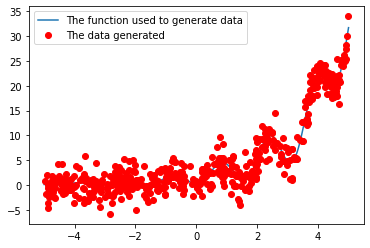

In [ ]:
# Example nonlinear function to generate synthetic regression data
def highly_nonlinear_function(x):
    y = 0.2 * np.exp(x) + (3 * np.exp(0.5 * x) - 0.2 * np.exp(x)) * np.square(np.sin(2 * x))
    return y

xx = np.linspace(-5, 5, 2000)
yy = highly_nonlinear_function(xx)

plt.plot(xx, yy, label='The function used to generate data')

x_vals = np.random.uniform(low=-5, high=5, size=(500,))
y_vals = highly_nonlinear_function(x_vals) + np.random.normal(0, 2, len(x_vals))

plt.plot(x_vals, y_vals, 'ro', label='The data generated')

plt.legend()

In [ ]:
import pandas as pd

df = pd.DataFrame(data={'X': x_vals, 'y': y_vals})

A very simple way to demonstrate underfitting is by using a linear model with nonlinear data. A neural network defined without any activation functions is by default a linear model. Let us see how a regression with such a neural network performs on this dataset.

In [ ]:
import tensorflow as tf

# Import necessary libraries from keras
from tensorflow import keras
from tensorflow.keras import layers

# Build a model using the "Sequential" API
linear_model = keras.Sequential([
      keras.Input(shape=(1)), # One input layer
      layers.Dense(64), # First hidden layer with 64 neurons, linear activation
      layers.Dense(1) # Final layer to predict y
  ])

# Compile the model
# Since this is a regression problem, we use mean squared error loss
# We use the stochastic gradient descent optimizer and provide it with a learning rate
linear_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001))

history = linear_model.fit(df['X'], df['y'], validation_split=0.1, epochs=50, batch_size=10, verbose=0)

63/63 [==============================] - 0s 1ms/step


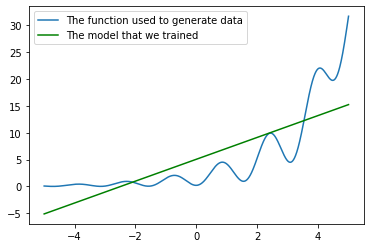

In [ ]:
xx_tensor = tf.convert_to_tensor(np.linspace(-5, 5, 2000))
yy_predicted = linear_model.predict(xx_tensor)

plt.plot(xx, yy, label='The function used to generate data')
plt.plot(xx, yy_predicted, 'g', label='The model that we trained')
plt.legend()

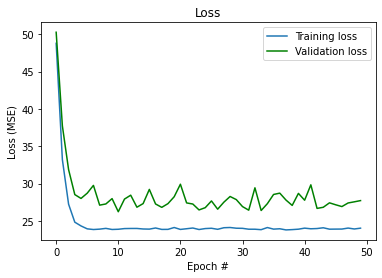

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss')
plt.legend()

In this case, the training loss and validation loss stagnate.

#### 1.2.1 Case 2: Model needs to be trained longer

Let us improve the complexity of the model, but train it for only a few epochs, to demonstrate underfitting.

In [ ]:
# Build a model using the "Sequential" API
nonlinear_model = keras.Sequential([
      keras.Input(shape=(1)), # One input layer
      layers.Dense(64, activation='relu'), # First hidden layer with 64 neurons, ReLU activation
      layers.Dense(64, activation='relu'), # Second hidden layer with 64 neurons, ReLU activation
      layers.Dense(1) # Final layer to predict y
  ])

# Compile the model
# Since this is a regression problem, we use mean squared error loss
# We use the stochastic gradient descent optimizer and provide it with a learning rate
nonlinear_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001))

history = nonlinear_model.fit(df['X'], df['y'], validation_split=0.1, epochs=5, batch_size=10, verbose=0)

63/63 [==============================] - 0s 1ms/step


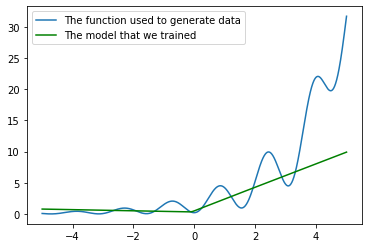

In [ ]:
xx_tensor = tf.convert_to_tensor(np.linspace(-5, 5, 2000))
yy_predicted = nonlinear_model.predict(xx_tensor)

plt.plot(xx, yy, label='The function used to generate data')
plt.plot(xx, yy_predicted, 'g', label='The model that we trained')
plt.legend()

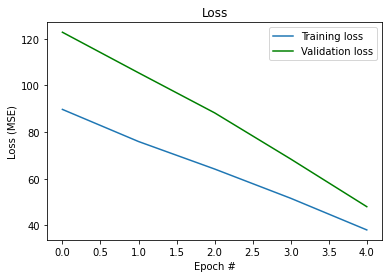

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss')
plt.legend()

In this case the training loss and the validation loss are still going down when the training ends.

### 1.3 Overfitting in a neural network

Overfitting occurs when the model is so complex that it can "memorize" the training data. This means, the model will fit **extremely** well to the training data, but will very **poorly generalize** to new data. What does the loss curve for an overfitting model look like? Hint: you saw this in the notebook on classification of images of flowers.

## 2 Addressing underfitting and overfitting by hyperparameter tuning

There is an art to building the right neural network - one that is complex enough to capture your data's variance, while at the same time not so complex that it memorizes the training data and cannot generalize. Getting these parameters right often involves playing around with **hyperparameters** - the aspects of your model that you set before training the model. Examples of hyperparameters are: the number of neurons per layer, the number of layers, the number of convolutional filters, the learning rate, the batch size, and the number of epochs to train for. There are two ways of adusting hyperparameters:
1. Manually, with trial-and-error
2. Using the Keras Tuner
In this section, we will go through a very brief tutorial of the Keras Tuner. There is a lot more information about the Keras Tuner available on the [documentation page](https://keras.io/keras_tuner/) and this [blogpost](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html), for those interested.

The steps in this section follow this [tutorial](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [ ]:
# Install with pip if not available
!pip install -q -U keras-tuner

import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.0 MB/s eta 0:00:00


In [ ]:
# Load Fashion MNIST Dataset
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

4422102/4422102 [==============================] - 0s 0us/step


### 2.1 Define the model

When you build a model for hypertuning, you also define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a *hypermodel*.

In this tutorial, you use a model builder function to define the image classification model. The model builder function returns a compiled model and uses hyperparameters you define inline to hypertune the model.

In [ ]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

### 2.2 Instantiate the tuner and perform hypertuning

Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`. In this tutorial, you use the [Hyperband](https://arxiv.org/pdf/1603.06560.pdf) tuner.

To instantiate the Hyperband tuner, you must specify the hypermodel, the `objective` to optimize and the maximum number of epochs to train (`max_epochs`).

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

### 2.3 Early stopping

When training a neural network, we may sometimes wish it to stop training before the number of alloted epochs is over, because the validation loss isn't improving or getting worse. We do this by means of a **callback function**. A callback function is triggered when a certain condition is met. Keras comes with several built-in callback functions, one of which monitors validation loss and stops the training early if needed. The "patience" parameter ensures the training doesn't stop immediately when the validation loss goes up, but rather waits for a few more epochs to see if the validation loss goes down again first.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run the hyperparameter search. The arguments for the search method are the same as those used for `tf.keras.model.fit` in addition to the callback above.

In [ ]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 01m 23s]
val_accuracy: 0.890999972820282

Best val_accuracy So Far: 0.8924166560173035
Total elapsed time: 00h 13m 54s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.001.



### 2.4 Train the model

Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.5015 - accuracy: 0.8227 - val_loss: 0.3861 - val_accuracy: 0.8622
Epoch 2/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3738 - accuracy: 0.8638 - val_loss: 0.3817 - val_accuracy: 0.8646
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3347 - accuracy: 0.8777 - val_loss: 0.3473 - val_accuracy: 0.8736
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3081 - accuracy: 0.8865 - val_loss: 0.3833 - val_accuracy: 0.8603
Epoch 5/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2917 - accuracy: 0.8924 - val_loss: 0.3225 - val_accuracy: 0.8858
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2728 - accuracy: 0.8982 - val_loss: 0.3308 - val_accuracy: 0.8837
Epoch 7/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2605 - accuracy: 0.9021 - val_loss: 0.3478 - val_accuracy

Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/32
1500/1500 [==============================] - 6s 3ms/step - loss: 0.4980 - accuracy: 0.8232 - val_loss: 0.4182 - val_accuracy: 0.8494
Epoch 2/32
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3744 - accuracy: 0.8652 - val_loss: 0.3615 - val_accuracy: 0.8700
Epoch 3/32
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3369 - accuracy: 0.8772 - val_loss: 0.3323 - val_accuracy: 0.8788
Epoch 4/32
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3094 - accuracy: 0.8853 - val_loss: 0.3385 - val_accuracy: 0.8795
Epoch 5/32
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2913 - accuracy: 0.8923 - val_loss: 0.3358 - val_accuracy: 0.8792
Epoch 6/32
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2724 - accuracy: 0.8996 - val_loss: 0.3170 - val_accuracy: 0.8876
Epoch 7/32
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2627 - accuracy: 0.9028 - val_loss: 0.3403 - val_accuracy:

Now evaluate the hypermodel on the test data.

In [ ]:
eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.4663 - accuracy: 0.8865
[test loss, test accuracy]: [0.46633538603782654, 0.8865000009536743]


## 3 Addressing overfitting by regularization

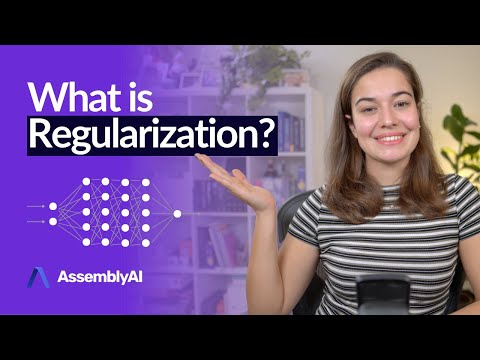

In [ ]:
YouTubeVideo("EehRcPo1M-Q", width=800, height=500)

Sometimes the easiest way to prevent a complex model from overfitting to training data is to add regularization parameters to the model. There are 3 main ways of adding regularization to a neural network. They are:
1. **Batch normalization:** Batch normalization is a technique used in neural networks to normalize the inputs of each layer by subtracting the mean and dividing by the standard deviation of the batch of inputs. It introduces two learnable parameters that allow the network to learn an optimal scale and shift for the normalized inputs. During training, the statistics used to normalize the inputs are computed over each mini-batch of inputs rather than the entire training set. 
2. **L1 and L2 regularization:** This type of regularization involves adding an additional term to the loss function during training to penalize large weights or biases. In L1 regularization, the additional term is proportional to the absolute value of the weights and in L2 regularization, the additional term is proportional to the square of the weights.
3. **Dropout**: When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer. The neurons that are dropped out are randomly changed at each step.

We will see how these concepts can help with overfitting. For this, we will use the same flowers dataset as the previous notebook, and try to improve the model performance on this dataset.

228813984/228813984 [==============================] - 13s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/10
92/92 [==============================] - 17s 44ms/step - loss: 1.3286 - accuracy: 0.4271 - val_loss: 1.0680 - val_accuracy: 0.5790
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 0.9952 - accuracy: 0.6127 - val_loss: 0.9788 - val_accuracy: 0.6185
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8117 - accuracy: 0.6884 - val_loss: 0.9058 - val_accuracy: 0.6458
Epoch 4/10
92/92 [==============================] - 2s 21ms/step - loss: 0.5976 - accuracy: 0.7752 - val_loss: 0.8791 - val_accuracy: 0.6785
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.3805 - accuracy: 0.8644 - val_loss: 1.0192 - val_accuracy: 0.6567
Epoch 6/10
92/92 [==============================] - 2s 21ms/step - loss: 0.2270 -

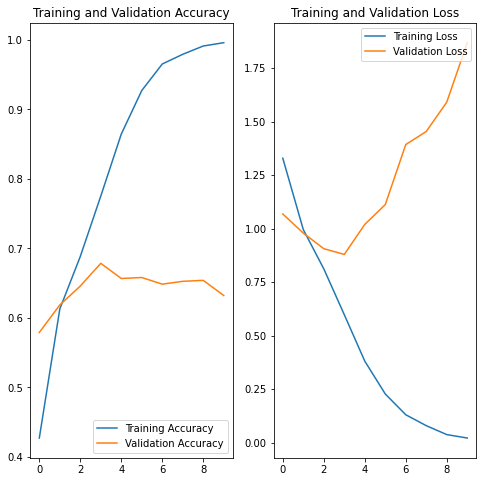

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download dataset

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# Load data using Keras dataloader
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize data
normalization_layer = layers.Rescaling(1./255)

# Create simple model (this will show overfitting)
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Visualize loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3.1 Batch normalization model

In this model we will add batch normalization to the layers to try and address the overfitting.

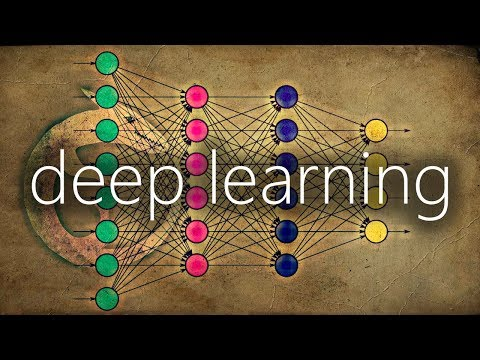

In [ ]:
YouTubeVideo("dXB-KQYkzNU", width=800, height=500)

Epoch 1/10
92/92 [==============================] - 5s 27ms/step - loss: 1.2689 - accuracy: 0.5381 - val_loss: 1.9588 - val_accuracy: 0.2398
Epoch 2/10
92/92 [==============================] - 2s 22ms/step - loss: 0.7767 - accuracy: 0.6969 - val_loss: 1.5338 - val_accuracy: 0.3583
Epoch 3/10
92/92 [==============================] - 2s 24ms/step - loss: 0.4971 - accuracy: 0.8229 - val_loss: 1.4136 - val_accuracy: 0.4019
Epoch 4/10
92/92 [==============================] - 2s 22ms/step - loss: 0.2587 - accuracy: 0.9203 - val_loss: 1.2777 - val_accuracy: 0.4673
Epoch 5/10
92/92 [==============================] - 2s 24ms/step - loss: 0.1081 - accuracy: 0.9785 - val_loss: 1.2197 - val_accuracy: 0.5518
Epoch 6/10
92/92 [==============================] - 2s 27ms/step - loss: 0.0311 - accuracy: 0.9980 - val_loss: 1.0181 - val_accuracy: 0.6376
Epoch 7/10
92/92 [==============================] - 2s 23ms/step - loss: 0.0087 - accuracy: 0.9997 - val_loss: 1.0779 - val_accuracy: 0.6376
Epoch 8/10
92

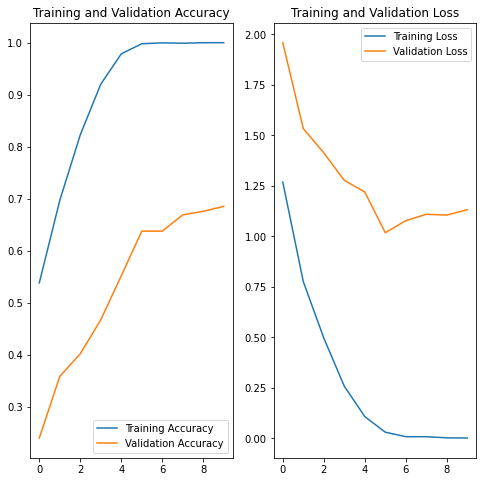

In [ ]:
bn_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes)
])

# Compile model
bn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model
epochs=10
history = bn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Visualize loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3.2 Regularization model

In this model we will add L1 and L2 regularization. Of course, you do not need to add both at the same time. You can also play around with the regularization coefficients. The default values used are l1=0.01 and l2=0.01. 

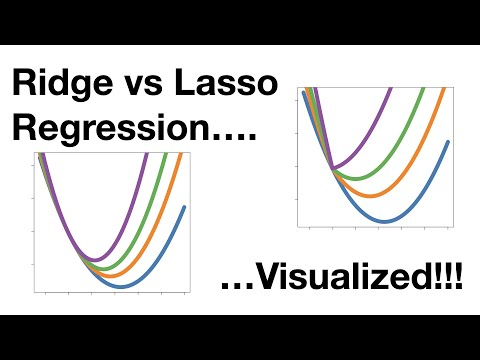

In [ ]:
YouTubeVideo("Xm2C_gTAl8c", width=800, height=500)

Epoch 1/10
92/92 [==============================] - 4s 23ms/step - loss: 29.2156 - accuracy: 0.3004 - val_loss: 6.9088 - val_accuracy: 0.4019
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 6.6970 - accuracy: 0.3835 - val_loss: 6.4612 - val_accuracy: 0.4428
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 6.3208 - accuracy: 0.4462 - val_loss: 6.3165 - val_accuracy: 0.4796
Epoch 4/10
92/92 [==============================] - 2s 22ms/step - loss: 6.1282 - accuracy: 0.4625 - val_loss: 6.1287 - val_accuracy: 0.4918
Epoch 5/10
92/92 [==============================] - 2s 21ms/step - loss: 6.0525 - accuracy: 0.4799 - val_loss: 5.8969 - val_accuracy: 0.4659
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 5.9499 - accuracy: 0.4966 - val_loss: 6.0408 - val_accuracy: 0.5163
Epoch 7/10
92/92 [==============================] - 2s 21ms/step - loss: 5.8650 - accuracy: 0.5014 - val_loss: 5.8055 - val_accuracy: 0.5109
Epoch 8/10
9

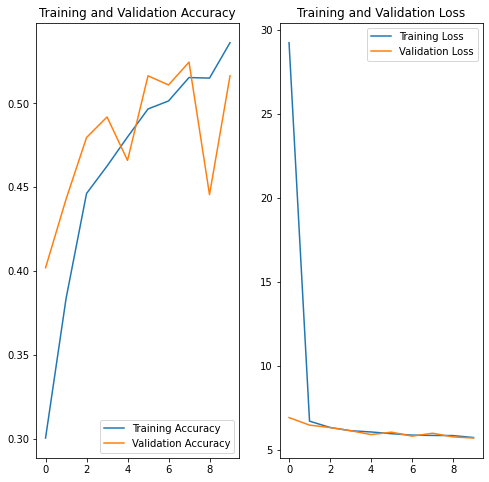

In [ ]:
reg_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer='l1_l2'), # Using both L1 and L2 with default coefficients. Check the documentation if you want to change this.
  layers.Dense(num_classes)
])

# Compile model
reg_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model
epochs=10
history = reg_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Visualize loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3.1 Dropout model

In this model we will add dropout layers to prevent the model from overfitting

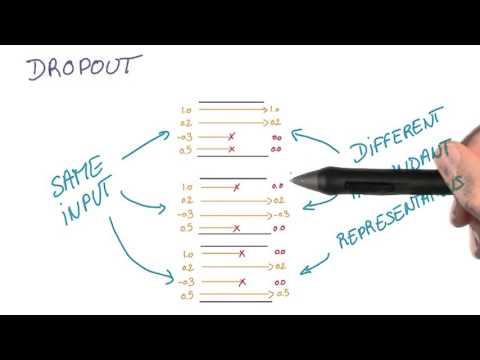

In [ ]:
YouTubeVideo("NhZVe50QwPM", width=800, height=500)

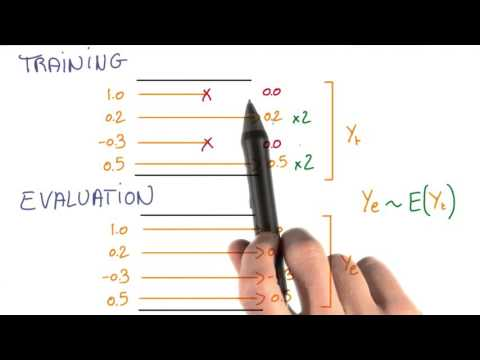

In [ ]:

YouTubeVideo("n1cmYQcqpfM", width=800, height=500)

Epoch 1/10
92/92 [==============================] - 4s 29ms/step - loss: 1.5454 - accuracy: 0.3082 - val_loss: 1.2162 - val_accuracy: 0.4918
Epoch 2/10
92/92 [==============================] - 2s 27ms/step - loss: 1.1890 - accuracy: 0.4901 - val_loss: 1.1379 - val_accuracy: 0.5545
Epoch 3/10
92/92 [==============================] - 2s 27ms/step - loss: 1.0562 - accuracy: 0.5780 - val_loss: 1.0324 - val_accuracy: 0.5763
Epoch 4/10
92/92 [==============================] - 3s 29ms/step - loss: 0.9656 - accuracy: 0.6161 - val_loss: 0.9483 - val_accuracy: 0.6063
Epoch 5/10
92/92 [==============================] - 3s 29ms/step - loss: 0.8648 - accuracy: 0.6744 - val_loss: 0.8759 - val_accuracy: 0.6417
Epoch 6/10
92/92 [==============================] - 3s 27ms/step - loss: 0.7353 - accuracy: 0.7108 - val_loss: 0.8750 - val_accuracy: 0.6526
Epoch 7/10
92/92 [==============================] - 3s 27ms/step - loss: 0.5983 - accuracy: 0.7735 - val_loss: 0.8399 - val_accuracy: 0.6703
Epoch 8/10
92

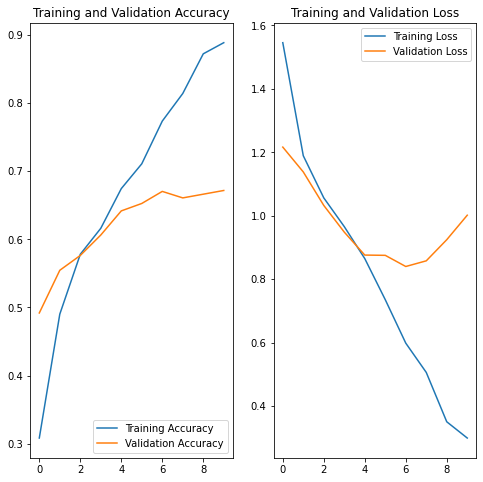

In [ ]:
dropout_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Randomly drops 20% of the neurons in this layer at each step
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Randomly drops 20% of the neurons in this layer at each step
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Randomly drops 20% of the neurons in this layer at each step
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2), # Randomly drops 20% of the neurons in this layer at each step
  layers.Dense(num_classes, name="outputs")
])

# Compile model
dropout_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model
epochs=10
history = dropout_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Visualize loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4 Exercises
You have seen that hyperparameter tuning, batch normalization, regularization and dropout can potentially help the issues of overfitting that we had with the simple flower classification model. Your task is to use some combination of these techniques to try and get the **highest possible validation accuracy** that you can on the flowers dataset. Note that multiple solutions may be possibl, use trial and error to play around and find what works best for you!

In [ ]:
# Your code here

# Note: The results are still not great, this is just to demonstrate various things you can try
# You will need more trial and error to get a better result (let's say, a validation accuracy of 75% or more)

# Instantiating a Keras tuner to search hyperparameter space
# Here, I will tune the number of hidden layers, the number of neurons per layer, the dropout fraction, and the learning rate
# You can tune several more hyperparameters, but keep in mind the more hyperparameters you tune and the larger the search-space you provide, the longer it will take


def model_builder(hp):
    model = keras.Sequential() # Instantiate a sequential model
    
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))) # Add a layer to normalize the input images

    # Choose between 3 and 4 convolutional "blocks"
    # A convolutional "block" consists of a convolutional layer, a max-pooling layer, and batch normalization

    # I will also add dropout. The dropout fraction is tunable, but I will keep it the same for all layers to save time
    # You can also have a different dropout fraction for each layer and tune them separately
    dropout = hp.Float(name="dropout", min_value=0.0, max_value=0.3, step=0.05)
   
    for cl in range(hp.Int('conv_layers', min_value=3, max_value=4, default=3)):
        # Tune the number of filters per convolutional layer
        # Choose an optimal value between 16-128
        conv_filters = hp.Int('filters_' + str(cl), min_value=16, max_value=128, step=16)
        model.add(layers.Conv2D(conv_filters, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())

        # Add dropout with a tunable probability
        model.add(layers.Dropout(dropout))

        # Add batch normalization
        model.add(layers.BatchNormalization())

    # Flatten the 2D output into 1D
    model.add(layers.Flatten())

    # Tune the number of units in the Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    # Add dropout with a tunable probability
    model.add(layers.Dropout(dropout))

    # Add a final dense layer for classification
    model.add(layers.Dense(num_classes, name="outputs"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory='my_dir',
                     project_name='hp_tuning_reg_exercise')

# Add early stopping to the tuning process
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Begin tuning
tuner.search(train_ds, validation_data=val_ds, epochs=50, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.\n
The optimal number of convolutional blocks is {best_hps.get('conv_layers')}.\n
The optimal dropout fraction is {best_hps.get('dropout')}.\n
The optimal number of units in the densely-connected hidden layer is {best_hps.get('units')}.\n
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 37s]
val_accuracy: 0.3910081684589386

Best val_accuracy So Far: 0.6416893601417542
Total elapsed time: 00h 25m 37s

The hyperparameter search is complete.

The optimal number of convolutional blocks is 4.

The optimal dropout fraction is 0.25.

The optimal number of units in the densely-connected hidden layer is 32.

The optimal learning rate for the optimizer is 0.01.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data with early stopping
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[stop_early])

Epoch 1/50
92/92 [==============================] - 15s 123ms/step - loss: 1.6361 - accuracy: 0.3764 - val_loss: 1.6546 - val_accuracy: 0.3774
Epoch 2/50
92/92 [==============================] - 11s 121ms/step - loss: 1.2868 - accuracy: 0.4479 - val_loss: 1.3434 - val_accuracy: 0.4387
Epoch 3/50
92/92 [==============================] - 11s 120ms/step - loss: 1.2189 - accuracy: 0.4636 - val_loss: 1.3012 - val_accuracy: 0.4469
Epoch 4/50
92/92 [==============================] - 11s 119ms/step - loss: 1.1603 - accuracy: 0.5109 - val_loss: 1.1860 - val_accuracy: 0.5477
Epoch 5/50
92/92 [==============================] - 11s 119ms/step - loss: 1.1080 - accuracy: 0.5385 - val_loss: 1.2637 - val_accuracy: 0.5327
Epoch 6/50
92/92 [==============================] - 11s 119ms/step - loss: 1.0587 - accuracy: 0.5623 - val_loss: 1.4773 - val_accuracy: 0.5136
Epoch 7/50
92/92 [==============================] - 11s 120ms/step - loss: 1.0323 - accuracy: 0.5889 - val_loss: 0.9856 - val_accuracy: 0.6076

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 96)      2688      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 96)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 96)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 90, 90, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 16)       

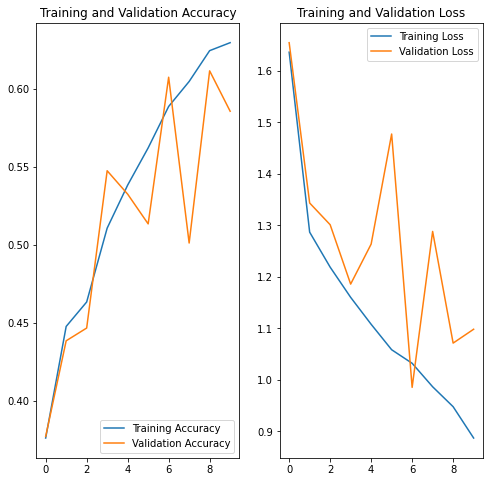

In [ ]:
# Print a summary of the tuned model
best_model.summary()

# Print a visualization of the tuned model
from tensorflow.keras.utils import plot_model

plot_model(best_model, show_shapes = True, dpi = 96)

# Plot the loss curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()